# Fig.6, Bifurcation Graph Iapp-Ko-Nai

## Importing useful functions and packages

In [1]:
### Importing packages and functions
import sys
import os
#### This should be set as the path of auto in your own computer, if you didn't add the path to your bashrc file
# os.environ['AUTO_DIR'] = '/auto-07p'
import numpy as np
import pylab, json, sympy, scipy
import matplotlib
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from matplotlib import rc
from copy import copy
### Add path to functions
sys.path.insert(1, './functions')
from m_generic_neuron_from_json import generic_neuron_from_json
from m_generic_neuron_from_json import load_mod
### Something for sympy to work with python 3
from sympy import S
from operator import itemgetter
### to create temp files in every run
import contextlib
import tempfile
import shutil
### Import auto stuff
import autoutils
import auto

In [2]:
## Hack for auto to work
%load_ext autoreload
%autoreload 2

In [3]:
# This is to run auto related stuff in a temporary folder (files are created in every run, and are not needed later)
@contextlib.contextmanager
def TemporaryDirectory(suffix="", prefix="tmp", dir=None):
    name = tempfile.mkdtemp(suffix, prefix, dir)
    try:
        yield name
    finally:
        shutil.rmtree(name)

In [4]:
# This is to save the data used to draw the bifurcation diagram
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

dir_sims='./Data/'

In [5]:
# This function extracts sympy expressions from the class neuron (neuron_snap) that are then used by auto, and runs an ode to find the steady state
def get_expressions_and_ss(neuron_snap,bifpar,autobifpart):
    # Creating a copy of neuron model to give to ode
    neuron_fromgen_4sim=copy(neuron_snap)
    # Creating a copy of neuron model to give to auto
    neuron_fromgen_4auto=copy(neuron_snap)
    neuron_fromgen_4auto.changing_pars(bifpar,pars4auto=True,strIapp=strIapp)
    #### Extracting expressions
    s_svars=neuron_fromgen_4auto.s_state_vars
    svarsexp=neuron_fromgen_4auto.svarsexp
    varrhs =zip(s_svars,svarsexp)
    varrhs=sorted(varrhs, key=itemgetter(0), reverse=True)
    var,rhs = zip(*varrhs);
    advar = sympy.S(["ad{}".format(k) for k in var])
    #Creating jacobian
    J = [[S(i).diff(j) for j in var] for i in rhs]
    adlinsys = [str(k) for k in
                (sympy.S("lam")*sympy.eye(len(advar))-sympy.Matrix(J).T)*sympy.Matrix(advar)]
    prcnorm=str((sympy.Matrix(sympy.S(advar)).T*sympy.Matrix(sympy.S(rhs)))[0,0] - sympy.S("dotZF/period"))
    spikecriterion = [str(S(k).subs([(i,"{}_left".format(i)) for i in var]))
                      for j,k in zip(var,rhs) if j=="v"]
    ##############################333##############################333##############################333
    ############## # Running model with ode, to find the steady state to auto as initial conditions   ###########333#
    ##############################333##############################333##############################333
    neuron_fromgen_4sim.changing_pars(bifpar,strIapp=strIapp)
    # Constant input stimuli
    I_exp1 = lambda t: 0 if t<0 else autobifpart[strIapp]
    t=np.linspace(0, 1000, int(1000.0/0.01))
    # Running ODE
    s_results, v_results=neuron_fromgen_4sim.stimulate_neuron(t,neuron_fromgen_4sim.current_state,I_exp1)
    inivals = ([float(v_results[:,s_results.index(j)][-1]) for j in var])
    return var,rhs,spikecriterion,J,inivals

# Defining setup for the continuations

### Defining neuron model

In [6]:
## Loading neuron model (file in the cfg folder)
model_name_p='MTM_W_sPNaS_sICD'
model_name_p0='MTM_W_sPNaS_snapshot_p0'
model_name_pp='MTM_W_sPNaS_snapshot_pp'

### How is the applied current parameter called
strIapp='I_app'
### creating a class neuron from m_generic_neuron_from_json that clasifies the expressions for ode
neuron_snap_p=generic_neuron_from_json(model_name_p+'.json',strIapp=strIapp)
neuron_snap_p0=generic_neuron_from_json(model_name_p0+'.json',strIapp=strIapp)
neuron_snap_pp=generic_neuron_from_json(model_name_pp+'.json',strIapp=strIapp)

In [7]:
### Check if parameters are the same in all models...
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p.p[ipar_s]:
            print(ipar_s+' is different in big model')
    else:
        print(ipar_s+' not in big model')
        
for ipar_s in neuron_snap_pp.p.keys():
    if ipar_s in neuron_snap_p0.p.keys():
        if neuron_snap_pp.p[ipar_s]!=neuron_snap_p0.p[ipar_s]:
            print(ipar_s+' is different in pump0 model')
    else:
        print(ipar_s+' not in pump0 model')
        
#         neuron.p[ipar_s]=ref_sim.c_neuron.p[ipar_s]

K_o not in big model
Na_i not in big model
K_i not in big model


### Defining bifurcation parameters


In [8]:
i_sn=[ii for ii,i_s in enumerate(neuron_snap_p.s_state_vars) if i_s=='K_i'][0]
K_i=neuron_snap_p.current_state[i_sn]

############################## Defining Na vector to store Iapp values

conc_lim=[3,28]# Boundaries for concentration space (Equal for Na_i and K_o)
d_conc_resol=3# Resolution of the concentration grid
# Create lists for the exploration of Na space
Na_v=scipy.linspace(conc_lim[0],conc_lim[1],(conc_lim[1]-conc_lim[0])/d_conc_resol).tolist()
inav=sorted(Na_v)[::2]

############# Define: How precise is exploration.. #########################
conc_lim=[3,28]# Boundaries for concentration space
d_conc_resol=2# Resolution of the concentration grid
K_vv=scipy.linspace(conc_lim[0],conc_lim[1],(conc_lim[1]-conc_lim[0])/d_conc_resol).tolist()


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [9]:
import autoutils
import auto

a_d_Bif_graph_data=[]


I_app=-5.0
for Na_i in inav:
    
    ## Defining Bifurcation parameters.. (In our case I_app and Ko)
    bifpar={}
    autobifpart={}
    I_app=-5.0
    K_o=5.0
    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    autobifpart[strIapp]=I_app
    bifpar['K_o'] = ['('+str(K_o)+"*mM)"]
    autobifpart['K_o']=K_o

    ## Making initial conditions the same
    i_sn=[ii for ii,i_s in enumerate(neuron_snap_p.s_state_vars) if i_s=='K_i'][0]
    K_i=neuron_snap_p.current_state[i_sn]
    bifpar['K_i'] = ['('+str(K_i)+"*mM)"]
    autobifpart['K_i']=K_i

    ## Making initial conditions the same
    bifpar['Na_i'] = ['('+str(Na_i)+"*mM)"]
    autobifpart['Na_i']=Na_i
    
    I_app=-5.0

    bifpar[strIapp] = [str(I_app)+"* uA/cm2"]
    autobifpart[strIapp]=I_app
    
    i_sn=[ii for ii,i_s in enumerate(neuron_snap_p.s_state_vars) if i_s=='Na_i'][0]
    neuron_snap_p.current_state[i_sn]=Na_i

    cc=0
    for j in neuron_snap_p.s_currents:
        if  'i_p'==j:
            i_p_i=neuron_snap_p.neuron_currents(neuron_snap_p.current_state)[cc]
        cc+=1

    if i_p_i>0:
        x_neuron=copy(neuron_snap_pp)
        model_name='MTM_W_sPNaS_snapshot_pp'
    else:
        x_neuron=copy(neuron_snap_p0)
        model_name='MTM_W_sPNaS_snapshot_p0'


    ### Using the function above to obtain the expressions from the model (needed to run AUTO)
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)

    ######## Running AUTO (to continue on the bifpar space) #############
    ### Continuing the ss forward to find the saddle node and the hopf bifurcations
    cwd_nonTemp = os.getcwd()
    with TemporaryDirectory(suffix="trial0") as t:
        os.chdir(t)
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
        bifpar=autobifpart, rhs=rhs, var=var,
        bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
        ic=[])
        #############################################################
        ##### Using AUTO to Continue steady state
        # Continuing Forward (ds>0) in I_app
        r1_fwd= auto.run(inivals, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
            PAR=autobifpart, ITNW=17, NWTN=13, NMX = 200000,NPR=10000,
            DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
            UZSTOP= {})

    ## Making sure the original path is restored
    os.chdir(cwd_nonTemp)
    ###### HEre we store the continuation in np arrays vectors
    v_s_par=[strIapp]

    v_s_var=[]
    for i in range(len(unames)):
        v_s_var.append(unames[i+1])

    m_res_par=[]
    for i_s in v_s_par:
        m_res_par.append(r1_fwd[i_s])

    m_res_statev=[]
    for i_s in v_s_var:
            m_res_statev.append(r1_fwd[i_s])


    ### Extracting sadle node and Hopf from continuation, to continue them later
    sn0=r1_fwd.getLabel('LP')[0]
    s1HB = r1_fwd('HB')[0]
    print('Nai'+str(Na_i)+'Found hopf!!')
    ################# continuing orbit #######################
    ### Starting from the hopf point backwards (ds<0) in I_app until the onset of spiking is reached..
    with TemporaryDirectory(suffix="trial0") as t:
        os.chdir(t)
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        r1_period0 = auto.run(s1HB, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=['I_app','period'], ILP=1, ISW=1,IPS=2,
            ITNW=17, NWTN=13, NMX=100000, NPR=3000,
            DS=-1e-2, DSMIN=-1e-3, DSMAX=-1e-1, NTST= 300,
            SP=['BT','LP','HB','BP','CP'],
            UZSTOP={'period': 100})

    os.chdir(cwd_nonTemp)
    ############ Extracting info from AUTO object
    #############################################################
    ##### Finding limit cycle onset (period>>0)
    try:
        lc_onset = r1_period0.getLabel('LP')[0]
    except:
        pass
    try:
        lc_onset = r1_period0.getLabel('UZ')[0]
    except:
        pass


    ###### HEre we extract the information AUTO calculated and store it in numpy arrays     
    m_res_par_lc=[]
    for i_s in v_s_par:
        m_res_par_lc.append(r1_period0[i_s])

    m_res_statev_lc=[]
    for i_s in v_s_var:
        m_res_statev_lc.append(r1_period0['MAX '+i_s])

    ############ Continuing the hopf point backwards to find the limit cycle onset (period>>0). ############
    ### Extracting limit cycle onset
    lc=r1_period0.getLabel('UZ')[0]
    ################# Find Bistability in the concs space ######################
    ############################################################################
    ############################################################################
    ds_resol=1e-4
    ################## Continuing the saddle node in the plane Ko-Iapp #################
    #######################################################################
    #######################################################################
    ##############      K++ conc           #############################
    ##### Saddle node
    ### First continuing the sn in the Ko-I_app plane..
    sn_t0=copy(sn0)
    with TemporaryDirectory(suffix="trial0") as t:
        os.chdir(t)
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        # Continuing Backward (ds<0)
        r_ko_sn_b= auto.run(sn_t0,  e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=['K_o','I_app'], ISP=1, ILP=1, ISW=2, SP=['LP','HB','BP'],
                ITNW=7, NWTN=3, NMX=500000, NPR=500000,
                DS= -1* ds_resol, DSMAX= -1 * ds_resol*10, UZR= {"K_o":K_vv[:]},
                UZSTOP= {'K_o': [K_vv[0]-0.1, K_vv[-1]+0.1]})
        # Continuing Forward (ds>0)
        r_ko_sn_f= auto.run(sn_t0, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=['K_o','I_app'], ISP=1, ILP=1, ISW=2, SP=['LP','HB','BP'],
            ITNW=7, NWTN=3, NMX=500000, NPR=500000,
            DS= ds_resol, DSMAX= ds_resol*10, UZR= {"K_o":K_vv[:]},
            UZSTOP= {'K_o': [K_vv[0]-0.1, K_vv[-1]+0.1]})

    os.chdir(cwd_nonTemp)

    ###### HEre we store the continuation in np arrays vectors
    v_s_par=['K_o','I_app']

    m_res_par_sn_KoIapp=[]
    for i_s in v_s_par:
        m_res_par_sn_KoIapp.append(np.concatenate([r_ko_sn_b[i_s],r_ko_sn_f[i_s]]))

    m_res_statev_sn_KoIapp=[]
    for i_s in v_s_var:
        m_res_statev_sn_KoIapp.append(np.concatenate([r_ko_sn_b[i_s],r_ko_sn_f[i_s]]))


    ######### Continuing the limit cycle onset in the Ko-I_app-period space #########

    #############################################################################
    #####Limit cycle onset (period>>0)
    #############################################################################
    lc_t0=copy(lc)
    nmx=1000
    with TemporaryDirectory(suffix="trial0") as t:
        os.chdir(t)
        ##############################333##############################333##############################333
        ##############                # Writing Auto readable files                   ###########333#
        ##############################333##############################333##############################333
        automodelname='autoOrbitSpike_'+model_name
        unames,pnames= autoutils.writeFP(automodelname,
            bifpar=autobifpart, rhs=rhs, var=var,
            bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
            ic=[])
        # Continuing Backward (ds<0)
        r_ko_lc_b = auto.run(lc_t0,  e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=['K_o','I_app','period'],
            ILP=1,
            ISW=1,
            IPS=2,
            ITNW=17, NWTN=13, NMX=nmx, NPR=1000, #Not sure if needed: PAR=autobifpar,
            DS= -1 * ds_resol*100, DSMAX= -1 * ds_resol*10*100, UZR= {"K_o":K_vv[:]}, #IID = 5, RL1=0.58, EPSL = 1e+1, EPSU = 1e+1, EPSS = 10, NTST = 500,
            UZSTOP= {'K_o': [K_vv[0]-0.1,K_vv[-1]+0.1]}
            )
        # Continuing Forward (ds>0)
        r_ko_lc_f = auto.run(lc_t0, e=automodelname,
            c=automodelname, parnames= pnames, unames=unames,
            ICP=['K_o','I_app','period'],
            ILP=1,
            ISW=1,
            IPS=2,
            ITNW=17, NWTN=13, NMX=nmx, NPR=1000, #Not sure if needed: PAR=autobifpar,
            DS= ds_resol*100, DSMAX= ds_resol*10*100, UZR= {"K_o":K_vv[:]},#UZR defines the values to be stored when the continuation passes over them
            UZSTOP= {'K_o': [K_vv[0]-0.1,K_vv[-1]+0.1]}
            )

    os.chdir(cwd_nonTemp)
    
    s_x=1;s_y=0
    ###### HEre we store the continuation in np arrays vectors
    v_s_par=['K_o','I_app','period']

    m_res_par_lc_KoIapp=[]
    for i_s in v_s_par:
        m_res_par_lc_KoIapp.append(np.concatenate([r_ko_lc_b[i_s],r_ko_lc_f[i_s]]))

    m_res_statev_lc_KoIapp=[]
    for i_s in v_s_var:
        m_res_statev_lc_KoIapp.append(np.concatenate([r_ko_lc_b['MAX '+i_s],r_ko_lc_f['MAX '+i_s]]))

    ############# Finding hopf bifurcation (depolarization block) in Ko-Iapp space #############
    v_xx_flc=np.array(m_res_par_lc_KoIapp[s_x])
    v_yy_flc=np.array(m_res_par_lc_KoIapp[s_y])

    m_res_par_HF=[]
    m_res_statev_HF=[]
    ### Getting Hopf with a loop
    cc_hof=0
    for iii in np.concatenate([range(len(v_yy_flc))[::int(d_conc_resol/np.mean(np.diff(v_yy_flc)))],np.array([range(len(v_yy_flc))[-1]])]):
        I_api=v_xx_flc[iii]-5.0
        
        bifpar["I_app"] = ['('+"{:.3f}".format(I_api)+"* uA/cm2)"]
        autobifpart["I_app"]=float("{:.3f}".format(I_api))
        bifpar['K_o'] = ['('+"{:.3f}".format(v_yy_flc[iii])+"*mM)"]
        autobifpart['K_o']=float("{:.3f}".format(v_yy_flc[iii]))
        ### Get inivals for each parameter combination
        var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
        try:
            with TemporaryDirectory(suffix="trial0"+str(iii)) as t:
                os.chdir(t)
                ##############################333##############################333##############################333
                ##############                # Writing Auto readable files                   ###########333#
                ##############################333##############################333##############################333
                automodelname='autoOrbitSpike_'+model_name
                unames,pnames= autoutils.writeFP(automodelname,
                    bifpar=autobifpart, rhs=rhs, var=var,
                    bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
                    ic=inivals)
                #############################################################
                ##### Using AUTO to Continue steady state
                # Continuing Forward (ds>0) in I_app
                r1_fwd_hf_Ko= auto.run(inivals, e=automodelname,
                    c=automodelname, parnames= pnames, unames=unames,
                    ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                    PAR=autobifpart, ITNW=17, NWTN=13, NMX = 250000,NPR=10000,
                    DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
                    UZSTOP= {})

            os.chdir(cwd_nonTemp)
            sHB_Ko = r1_fwd_hf_Ko('HB')[0]
            m_res_par_HF.append([[sHB_Ko['K_o']],[sHB_Ko['I_app']]])
            m_res_statev_HF.append(sHB_Ko.coordarray)

        except:
            pass

        os.chdir(cwd_nonTemp)
        cc_hof+=1
        print('Done with..'+str(cc_hof)+'/'+str(len(np.concatenate([range(len(v_yy_flc))[::int(d_conc_resol/np.mean(np.diff(v_yy_flc)))],np.array([range(len(v_yy_flc))[-1]])]))))
    
    print('Nai'+str(Na_i)+'first line hopf!!')
    ######### Running one more time for a higher Ko to make the hopf line complete #########
    #### One more hopf to make the hopf line more complete
    I_api=v_xx_flc[iii]-5.0
    bifpar["I_app"] = ['('+"{:.3f}".format(I_api)+"* uA/cm2)"]
    autobifpart["I_app"]=float("{:.3f}".format(I_api))
    autobifpart['K_o']=float("{:.3f}".format(v_yy_flc[iii]+5.0))
    bifpar['K_o'] = ['('+"{:.3f}".format(v_yy_flc[iii]+5.0)+"*mM)"]
    var,rhs,spikecriterion,J,inivals=get_expressions_and_ss(x_neuron,bifpar,autobifpart)
    try:
        with TemporaryDirectory(suffix="trial0") as t:
            os.chdir(t)
            ##############################333##############################333##############################333
            ##############                # Writing Auto readable files                   ###########333#
            ##############################333##############################333##############################333
            automodelname='autoOrbitSpike_'+model_name
            unames,pnames= autoutils.writeFP(automodelname,
                bifpar=autobifpart, rhs=rhs, var=var,
                bc=['{0}_left-{0}_right'.format(v) for v in var] + spikecriterion,
                ic=[])
            #############################################################
            ##### Using AUTO to Continue steady state
            # Continuing Forward (ds>0) in I_app
            r1_fwd_hf_Ko= auto.run(inivals, e=automodelname,
                c=automodelname, parnames= pnames, unames=unames,
                ICP=[strIapp], ISP=1,ILP=1, ISW = 1, SP=['LP','HB','BP'],
                PAR=autobifpart, ITNW=17, NWTN=13, NMX = 250000,NPR=10000,
                DS= 1 * 1e-3, DSMAX= 1 * 1e-2, STOP=['HB'],
                UZSTOP= {})

        os.chdir(cwd_nonTemp)
        sHB_Ko = r1_fwd_hf_Ko('HB')[0]
        m_res_par_HF.append([[sHB_Ko['K_o']],[sHB_Ko['I_app']]])
        m_res_statev_HF.append(sHB_Ko.coordarray)
    except:
        pass
        
    
    os.chdir(cwd_nonTemp)
    m_res_par_HF0=np.concatenate(m_res_par_HF,axis=1)

    print('Nai'+str(Na_i)+'last line hopf!!')
    # Result: Continuation of the Hopf, saddle node and the limit cycle onset in the Ko-Iapp plane
    ### Saving continuation...
    d_Bif_graph_data={}
    d_Bif_graph_data['Bif_parameters']=v_s_par
    d_Bif_graph_data['state_pars']=v_s_var
    d_Bif_graph_data['saddle_node_par']=m_res_par_sn_KoIapp
    d_Bif_graph_data['saddle_node_var']=m_res_statev_sn_KoIapp
    d_Bif_graph_data['limit_cycle_onset_par']=m_res_par_lc_KoIapp
    d_Bif_graph_data['limit_cycle_onset_var']=m_res_statev_lc_KoIapp
    d_Bif_graph_data['Hopf_par']=m_res_par_HF0
    d_Bif_graph_data['Hopf_var']=m_res_statev_HF
    
    x_neuron.changing_pars(bifpar,strIapp=strIapp)
    d_Bif_graph_data['d_pars']=x_neuron.p
    d_Bif_graph_data['model_name']=model_name

    a_d_Bif_graph_data.append(d_Bif_graph_data)
    print('Nai'+str(Na_i)+'!!!!!  Finished !!!!!!')

dir_folder='./Data/'
file_n='Bifurcation_Graph_Iapp_Ko_'+model_name+'_all_Nais'

save_obj(a_d_Bif_graph_data,dir_folder+file_n)

initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 3.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  6255  LP    2   1.26579E+00   6.46272E+01  -6.46195E+01   5.49675E-02   2.38039E-02   9.92569E-01
   1     1        3  -3.15817E+01   5.33048E+01  -5.32968E+01   2.35172E-01   1.58662E-01   8.81392E-01
   1  7236  LP    4  -1.03579E+02   4.74210E+01  -4.74143E+01   3.83189E-01   3.09874E-01  

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   2  2420  UZ   25   3.00000E+00   6.43299E+01  -6.43222E+01   5.75366E-02   2.52308E-02   9.91987E-01   2.57734E+00
   2  2555  UZ   26   2.90000E+00   6.43079E+01  -6.43002E+01   5.77308E-02   2.53395E-02   9.91942E-01   2.66457E+00

 Total Time    0.302E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ... done
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   2   310  UZ   25   5.27273E+00   6.46549E+01  -6.46472E+01   5.47328E-02   2.36745E-02   9.92621E-01   1.12969E+00
   2  2769  UZ   26   7.54545E+00   6.48296E+01  -6.48220E+01   5.32735E-02   2.28738E-02   9.92941E-01   2.12291E-01
   2  5143  UZ   27   9.81818E+00   6.49461E+01  -6.49385E+01   5.23194E-02   2.23539E-02   9.93146E-01  -4.60

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  18   391  UZ   36   1.90903E+01   5.48633E+01   7.96053E+01   7.34430E-01   9.99990E-01   9.21741E-01  -2.91488E+01   9.99996E+01
  18   409  UZ   37   1.86205E+01   5.47183E+01   7.89667E+01   7.31824E-01   9.99764E-01   9.18743E-01  -3.07325E+01   9.99996E+01
  18   412  UZ   38   1.92252E+01   5.47511E+01   7.92409E+01   7.34630E-01   1.00091E+00   9.19652E-01  -3.05250E+01   9.99996E+01
  18  1000  EP   39   2.34122E+01   5.14564E+01   7.14931E+01   7.39792E-01   9.99660E-01   8.34249E-01  -9.92569E+01   9.99996E+01

 Total Time    0.421E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -3.696, 2: 5.0, 3: 150.0, 4: 3.0, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  4991  LP    2   1.26579E+00   6.46272E+01  -6.46195E+01   5.49675E-02   2.38039E-02   9.92569E-01
   1     1        3  -4.41795E+01   5.22748E+01  -5.22669E+01   2.59625E-01   1.81346E-01   8.51153E-01
   1  5972  LP    4  -1.03579E+02   4.74210E+01  -4.74143E+01   3.83189E-01   3.09874E-01

   1     1        3  -2.07133E+00   6.23189E+01  -6.23111E+01   7.76561E-02   3.70430E-02   9.86679E-01
   1     2        4  -1.00101E+02   5.12965E+01  -5.12888E+01   2.83660E-01   2.04540E-01   8.16839E-01
   1     3        5  -2.00059E+02   4.84080E+01  -4.84010E+01   3.57540E-01   2.81300E-01   6.82026E-01
   1     4        6  -2.99982E+02   4.47918E+01  -4.47855E+01   4.50683E-01   3.89893E-01   4.63441E-01
   1   214  LP    7  -3.01985E+02   4.43072E+01  -4.43008E+01   4.62832E-01   4.05055E-01   4.33509E-01
   1     5        8  -2.04228E+02   4.11707E+01  -4.11632E+01   5.37821E-01   5.03941E-01   2.60550E-01
   1     6        9  -1.04236E+02   3.98820E+01  -3.98737E+01   5.66423E-01   5.44096E-01   2.04821E-01
   1     7       10  -4.24108E+00   3.88828E+01  -3.88738E+01   5.87605E-01   5.74693E-01   1.68481E-01
   1     8       11   9.57552E+01   3.80247E+01  -3.80149E+01   6.05080E-01   6.00470E-01   1.41841E-01
   1     9       12   1.95752E+02   3.72526E+01  -3.72420E+01   

   1     8       11  -2.32964E+02   4.02198E+01  -4.02118E+01   5.59063E-01   5.33634E-01   2.18458E-01
   1     9       12  -1.32972E+02   3.89672E+01  -3.89582E+01   5.85851E-01   5.72132E-01   1.71324E-01
   1    10       13  -3.29774E+01   3.79563E+01  -3.79464E+01   6.06444E-01   6.02503E-01   1.39888E-01
   1    11       14   6.70187E+01   3.70713E+01  -3.70605E+01   6.23711E-01   6.28460E-01   1.16780E-01
   1  8758  HB   15   1.54483E+02   3.63630E+01  -3.63515E+01   6.37016E-01   6.48745E-01   1.00953E-01
   1    12       16   1.67012E+02   3.62654E+01  -3.62538E+01   6.38813E-01   6.51503E-01   9.89437E-02
   1    13       17   2.67009E+02   3.55144E+01  -3.55020E+01   6.52357E-01   6.72411E-01   8.47615E-02
   1    14       18   3.67007E+02   3.48044E+01  -3.47911E+01   6.64699E-01   6.91640E-01   7.32575E-02
   1    15       19   4.67005E+02   3.41262E+01  -3.41121E+01   6.76075E-01   7.09484E-01   6.37900E-02
   1    16       20   5.67002E+02   3.34737E+01  -3.34588E+01   

   1    15       19   1.65849E+02   3.55756E+01  -3.55632E+01   6.51273E-01   6.70731E-01   8.58352E-02
   1    16       20   2.65846E+02   3.48081E+01  -3.47948E+01   6.64636E-01   6.91540E-01   7.33136E-02
   1    17       21   3.65844E+02   3.40795E+01  -3.40653E+01   6.76844E-01   7.10693E-01   6.31876E-02
   1    18       22   4.65841E+02   3.33816E+01  -3.33665E+01   6.88109E-01   7.28454E-01   5.48873E-02
   1    19       23   5.65839E+02   3.27088E+01  -3.26929E+01   6.98580E-01   7.45008E-01   4.80113E-02
   1    20       24   6.65837E+02   3.20574E+01  -3.20405E+01   7.08365E-01   7.60491E-01   4.22663E-02
   1    21       25   7.65835E+02   3.14243E+01  -3.14065E+01   7.17550E-01   7.75005E-01   3.74314E-02
   1    22       26   8.65833E+02   3.08073E+01  -3.07886E+01   7.26200E-01   7.88633E-01   3.33366E-02
   1    23       27   9.65831E+02   3.02047E+01  -3.01851E+01   7.34371E-01   8.01444E-01   2.98490E-02
   1    24       28   1.06583E+03   2.96151E+01  -2.95946E+01   

   1    23       27   6.75500E+02   3.14355E+01  -3.14178E+01   7.17389E-01   7.74751E-01   3.75116E-02
   1    24       28   7.75498E+02   3.07906E+01  -3.07719E+01   7.26430E-01   7.88994E-01   3.32336E-02
   1    25  EP   29   8.75496E+02   3.01620E+01  -3.01424E+01   7.34940E-01   8.02332E-01   2.96195E-02

 Total Time    0.127E+02
autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..9/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -100.791, 2: 23.347, 3: 150.0, 4: 3.0, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -9.04785E+01   9.13615E+02  -9.13615E+02   3.99959E-83   5.16512E-94   1.00000E+00
   1     2        3  -8.01624E+01   8.14149E+02  -8.14148E+02   1.85453E-73   3.24182E-83   1.00000E+00
   1     3        4  -6.98464E+01   7.14682E+02  -7.14682E+02   8.45

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..10/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -104.257, 2: 23.412, 3: 150.0, 4: 3.0, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1  EP    2  -1.04257E+02      Infinity   1.11787+253   6.00032E-67   6.01393-154   1.30371E-76

 Total Time    0.653E-03
autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ... done
Done with..11/11
Nai3.0first line hopf!!


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -104.257, 2: 28.412, 3: 150.0, 4: 3.0, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o


/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_p0.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1  EP    2  -1.04257E+02      Infinity   1.11787+253   6.00032E-67   6.01393-154   1.30371E-76

 Total Time    0.657E-03
autoOrbitSpike_MTM_W_sPNaS_snapshot_p0 ... done
Nai3.0last line hopf!!


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG


Nai3.0!!!!!  Finished !!!!!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 10.142857142857142, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  6545  LP    2   1.55997E+00   6.41013E+01  -6.40936E+01   5.95797E-02   2.63794E-02   9.91510E-01
   1     1        3  -2.81063E+01   5.22278E+01  -5.22199E+01   2.60764E-01   1.82425E-01   8.49632E-01
   1  2260  LP    4  -5.02682E+01   4.86514E+01

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   2  2449  UZ   25   3.00000E+00   6.36631E+01  -6.36554E+01   6.36662E-02   2.87127E-02   9.90513E-01   2.88317E+00
   2  2587  UZ   26   2.90000E+00   6.36288E+01  -6.36210E+01   6.39958E-02   2.89030E-02   9.90431E-01   2.97139E+00

 Total Time    0.310E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   2   312  UZ   25   5.27273E+00   6.41402E+01  -6.41325E+01   5.92280E-02   2.61808E-02   9.91593E-01   1.42292E+00
   

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  15   217  UZ   35   1.66364E+01   5.73430E+01   5.54223E+01   6.89768E-01   9.99867E-01   9.56867E-01  -8.16926E+00   1.00000E+02
  15   381  UZ   36   1.89091E+01   5.45871E+01   5.29201E+01   6.96219E-01   9.99553E-01   9.16972E-01  -2.56168E+01   1.00000E+02
  15   884  UZ   37   2.34545E+01   5.13573E+01   4.55498E+01   7.03867E-01   9.99253E-01   8.31443E-01  -8.18476E+01   1.00000E+02
  15   889  UZ   38   2.33605E+01   5.13368E+01   4.59817E+01   7.04993E-01   9.99932E-01   8.30767E-01  -8.22119E+01   1.00000E+02
  15   905  UZ   39   2.34545E+01   5.12785E+01   4.62904E+01   7.05167E-01   9.98933E-01   8.28573E-01  -8.38304E+01   1.00000E+02
  15  1000  EP   40   2.41058E+01   5.09001E+01   4.43475E+01   7.05871E-01   9.98944E-01   8.14787E-01  -9.44502E+01   1.00000E+02

 Total Time    0.448E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -3.402, 2: 5.0, 3: 150.0, 4: 10.142857142857142, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  4996  LP    2   1.55997E+00   6.41013E+01  -6.40936E+01   5.95797E-02   2.63794E-02   9.91510E-01
   1     1        3  -4.34738E+01   5.02872E+01  -5.02797E+01   3.09100E-01   2.30044E-01   7.75378E-01
   1   711  LP    4  -5.02682E+01   4.86514E+01  -4.86444E+01   3.51220E-0

   1     1        3  -1.92856E+01   5.53579E+01  -5.53497E+01   1.89728E-01   1.19025E-01   9.26121E-01
   1     2        4  -1.19091E+02   4.95414E+01  -4.95341E+01   3.28205E-01   2.49838E-01   7.40755E-01
   1  8779  LP    5  -2.06632E+02   4.49625E+01  -4.49562E+01   4.46377E-01   3.84575E-01   4.74071E-01
   1     3        6  -1.94545E+02   4.36954E+01  -4.36889E+01   4.77982E-01   4.24294E-01   3.96527E-01
   1     4        7  -9.45769E+01   4.12987E+01  -4.12914E+01   5.34902E-01   4.99919E-01   2.66632E-01
   1     5        8   5.41450E+00   3.99923E+01  -3.99842E+01   5.64030E-01   5.40684E-01   2.09199E-01
   1     6        9   1.05409E+02   3.89657E+01  -3.89567E+01   5.85883E-01   5.72179E-01   1.71272E-01
   1     7       10   2.05405E+02   3.80812E+01  -3.80715E+01   6.03950E-01   5.98789E-01   1.43471E-01
   1  8266  HB   11   2.87991E+02   3.74189E+01  -3.74085E+01   6.17015E-01   6.18343E-01   1.25393E-01
   1     8       12   3.05400E+02   3.72852E+01  -3.72747E+01   

   1     8       11  -1.45019E+01   3.86951E+01  -3.86859E+01   5.91485E-01   5.80376E-01   1.62303E-01
   1     9       12   8.54928E+01   3.76644E+01  -3.76542E+01   6.12219E-01   6.11136E-01   1.31832E-01
   1  4203  HB   13   1.27423E+02   3.72709E+01  -3.72604E+01   6.19878E-01   6.22661E-01   1.21657E-01
   1    10       14   1.85481E+02   3.67538E+01  -3.67427E+01   6.29731E-01   6.37608E-01   1.09409E-01
   1    11       15   2.85477E+02   3.59216E+01  -3.59096E+01   6.45077E-01   6.61146E-01   9.21764E-02
   1    12       16   3.85474E+02   3.51453E+01  -3.51324E+01   6.58829E-01   6.82476E-01   7.85646E-02
   1    13       17   4.85472E+02   3.44116E+01  -3.43978E+01   6.71337E-01   7.02039E-01   6.76052E-02
   1    14       18   5.85469E+02   3.37116E+01  -3.36969E+01   6.82834E-01   7.20128E-01   5.86541E-02
   1    15       19   6.85467E+02   3.30393E+01  -3.30238E+01   6.93483E-01   7.36947E-01   5.12607E-02
   1    16       20   7.85465E+02   3.23903E+01  -3.23739E+01   

   1    15       19   3.93544E+02   3.42803E+01  -3.42664E+01   6.73525E-01   7.05475E-01   6.58209E-02
   1    16       20   4.93541E+02   3.35301E+01  -3.35152E+01   6.85747E-01   7.24724E-01   5.65483E-02
   1    17       21   5.93539E+02   3.28124E+01  -3.27965E+01   6.96993E-01   7.42497E-01   4.90039E-02
   1    18       22   6.93536E+02   3.21219E+01  -3.21051E+01   7.07412E-01   7.58982E-01   4.27986E-02
   1    19       23   7.93534E+02   3.14546E+01  -3.14369E+01   7.17117E-01   7.74321E-01   3.76478E-02
   1    20       24   8.93532E+02   3.08076E+01  -3.07889E+01   7.26196E-01   7.88627E-01   3.33384E-02
   1    21       25   9.93530E+02   3.01784E+01  -3.01588E+01   7.34721E-01   8.01991E-01   2.97075E-02
   1    22       26   1.09353E+03   2.95653E+01  -2.95447E+01   7.42750E-01   8.14490E-01   2.66287E-02
   1    23       27   1.19353E+03   2.89665E+01  -2.89450E+01   7.50331E-01   8.26191E-01   2.40025E-02
   1    24       28   1.29352E+03   2.83809E+01  -2.83584E+01   

   1    23       27   9.25365E+02   2.99474E+01  -2.99275E+01   7.37778E-01   8.06761E-01   2.84979E-02
   1    24       28   1.02536E+03   2.93112E+01  -2.92902E+01   7.45998E-01   8.19517E-01   2.54714E-02
   1    25  EP   29   1.12536E+03   2.86909E+01  -2.86689E+01   7.53737E-01   8.31410E-01   2.29061E-02

 Total Time    0.127E+02
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Done with..9/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -92.29, 2: 23.87, 3: 150.0, 4: 10.142857142857142, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..10/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -99.45, 2: 24.106, 3: 150.0, 4: 10.142857142857142, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -8.91375E+01   9.02268E+02  -9.02267E+02   5.07106E-82   8.80947E-93   1.00000E+00
   1     2        3  -7.88214E+01   8.02801E+02  -8.02801E+02   2.34726E-72   5.52854E-82   1.00000E+00
   1     3        4  -6.85054E+01   7.03335E+02  -7.03

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..11/11
Nai10.142857142857142first line hopf!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -99.45, 2: 29.106, 3: 150.0, 4: 10.142857142857142, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -8.91375E+01   8.97697E+02  -8.97696E+02   1.41064E-81   2.76161E-92   1.00000E+00
   1     2        3  -7.88214E+01   7.98230E+02  -7.98230E+02   6.52478E-72   1.73302E-81   1.00000E+00
   1     3     

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Nai10.142857142857142last line hopf!!
Nai10.142857142857142!!!!!  Finished !!!!!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 17.285714285714285, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2   5.31253E+00   9.45979E+01  -9.45926E+01   2.12720E-04   2.68696E-05   9.99996E-01
   1  3096  LP    3   8.31426E+00   6.38026E+01  -6.37948E+01   6.23414E-02   2.79511E-02   9.9084

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   3  2478  UZ   25   3.00000E+00   6.32490E+01  -6.32412E+01   6.77377E-02   3.10836E-02   9.89466E-01   9.64655E+00
   3  2620  UZ   26   2.90000E+00   6.32035E+01  -6.31957E+01   6.81976E-02   3.13542E-02   9.89344E-01   9.73561E+00

 Total Time    0.314E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   3   313  UZ   25   5.27273E+00   6.38497E+01  -6.38420E+01   6.18988E-02   2.76978E-02   9.90951E-01   8.17653E+00
   

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  15   211  UZ   35   1.66368E+01   5.73053E+01   4.37312E+01   6.70276E-01   9.99578E-01   9.56607E-01  -7.13899E-01   1.00000E+02
  15   339  UZ   36   1.89091E+01   5.48976E+01   4.18637E+01   6.77678E-01   9.99084E-01   9.23021E-01  -1.36100E+01   1.00000E+02
  15   555  UZ   37   2.11818E+01   5.28944E+01   3.86609E+01   6.83635E-01   9.98888E-01   8.78793E-01  -3.66186E+01   1.00000E+02
  15   853  UZ   38   2.34632E+01   5.12252E+01   3.51862E+01   6.85581E-01   9.98049E-01   8.26905E-01  -6.93065E+01   1.00000E+02
  15  1000  EP   39   2.44256E+01   5.06113E+01   3.36893E+01   6.83675E-01   9.98813E-01   8.04004E-01  -8.51223E+01   1.00000E+02

 Total Time    0.414E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: 3.352, 2: 5.0, 3: 150.0, 4: 17.285714285714285, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  4999  LP    2   8.31426E+00   6.38026E+01  -6.37948E+01   6.23413E-02   2.79511E-02   9.90842E-01
   1  8900  LP    3  -2.51314E+01   4.94163E+01  -4.94091E+01   3.31427E-01   2.53231E-01   7.34627E-01
   1     1        4  -1.44374E+01   4.76375E+01  -4.76308E+01   3.77564E-01

   1     1        3  -1.61166E+01   5.45891E+01  -5.45809E+01   2.06176E-01   1.32984E-01   9.11548E-01
   1     2        4  -1.15923E+02   4.86425E+01  -4.86354E+01   3.51452E-01   2.74665E-01   6.94742E-01
   1  4689  LP    5  -1.62562E+02   4.53021E+01  -4.52957E+01   4.37769E-01   3.74033E-01   4.95302E-01
   1     3        6  -1.09616E+02   4.25964E+01  -4.25896E+01   5.04599E-01   4.58996E-01   3.33481E-01
   1     4        7  -9.63121E+00   4.08505E+01  -4.08429E+01   5.45057E-01   5.13973E-01   2.45770E-01
   1     5        8   9.03615E+01   3.96499E+01  -3.96415E+01   5.71422E-01   5.51252E-01   1.95852E-01
   1     6        9   1.90357E+02   3.86639E+01  -3.86546E+01   5.92128E-01   5.81319E-01   1.61295E-01
   1  8479  HB   10   2.75082E+02   3.79247E+01  -3.79148E+01   6.07073E-01   6.03440E-01   1.38996E-01
   1     7       11   2.90351E+02   3.77984E+01  -3.77884E+01   6.09577E-01   6.07180E-01   1.35477E-01
   1     8       12   3.90348E+02   3.70118E+01  -3.70010E+01   

   1     8       11   8.95412E+01   3.80910E+01  -3.80812E+01   6.03755E-01   5.98500E-01   1.43753E-01
   1  3173  HB   12   1.21180E+02   3.77675E+01  -3.77574E+01   6.10189E-01   6.08095E-01   1.34627E-01
   1     9       13   1.89527E+02   3.71104E+01  -3.70996E+01   6.22964E-01   6.27327E-01   1.17720E-01
   1    10       14   2.89523E+02   3.62267E+01  -3.62151E+01   6.39522E-01   6.52592E-01   9.81596E-02
   1    11       15   3.89520E+02   3.54104E+01  -3.53978E+01   6.54193E-01   6.75263E-01   8.29658E-02
   1    12       16   4.89517E+02   3.46441E+01  -3.46306E+01   6.67424E-01   6.95904E-01   7.08932E-02
   1    13       17   5.89514E+02   3.39170E+01  -3.39026E+01   6.79504E-01   7.14881E-01   6.11401E-02
   1    14       18   6.89512E+02   3.32216E+01  -3.32063E+01   6.90633E-01   7.32441E-01   5.31585E-02
   1    15       19   7.89510E+02   3.25528E+01  -3.25366E+01   7.00955E-01   7.48767E-01   4.65580E-02
   1    16       20   8.89508E+02   3.19065E+01  -3.18895E+01   

   1    15       19   5.21599E+02   3.35802E+01  -3.35654E+01   6.84944E-01   7.23458E-01   5.71220E-02
   1    16       20   6.21596E+02   3.28447E+01  -3.28289E+01   6.96495E-01   7.41711E-01   4.93186E-02
   1    17       21   7.21593E+02   3.21391E+01  -3.21223E+01   7.07157E-01   7.58580E-01   4.29416E-02
   1    18       22   8.21591E+02   3.14588E+01  -3.14411E+01   7.17057E-01   7.74226E-01   3.76779E-02
   1    19       23   9.21589E+02   3.08006E+01  -3.07820E+01   7.26292E-01   7.88777E-01   3.32955E-02
   1    20       24   1.02159E+03   3.01619E+01  -3.01422E+01   7.34942E-01   8.02336E-01   2.96186E-02
   1    21       25   1.12158E+03   2.95403E+01  -2.95197E+01   7.43070E-01   8.14987E-01   2.65123E-02
   1    22       26   1.22158E+03   2.89344E+01  -2.89128E+01   7.50731E-01   8.26805E-01   2.38712E-02
   1    23       27   1.32158E+03   2.83424E+01  -2.83199E+01   7.57969E-01   8.37855E-01   2.16122E-02
   1    24       28   1.42158E+03   2.77633E+01  -2.77398E+01   

   1    23       27   1.05250E+03   2.92110E+01  -2.91898E+01   7.47266E-01   8.21474E-01   2.50327E-02
   1    24       28   1.15250E+03   2.85819E+01  -2.85598E+01   7.55069E-01   8.33443E-01   2.24908E-02
   1    25  EP   29   1.25250E+03   2.79685E+01  -2.79453E+01   7.62421E-01   8.44583E-01   2.03295E-02

 Total Time    0.128E+02
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Done with..9/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -81.151, 2: 23.963, 3: 150.0, 4: 17.285714285714285, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNa

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..10/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -90.122, 2: 24.426, 3: 150.0, 4: 17.285714285714285, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -7.98095E+01   8.76866E+02  -8.76865E+02   1.49325E-79   5.04133E-90   1.00000E+00
   1     2        3  -6.94934E+01   7.77399E+02  -7.77398E+02   6.88367E-70   3.16292E-79   1.00000E+00
   1     3        4  -5.91774E+01   6.77933E+02  -6.7

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..11/11
Nai17.285714285714285first line hopf!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -90.122, 2: 29.426, 3: 150.0, 4: 17.285714285714285, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -7.98095E+01   8.72349E+02  -8.72349E+02   4.10268E-79   1.55891E-89   1.00000E+00
   1     2        3  -6.94934E+01   7.72883E+02  -7.72882E+02   1.88984E-69   9.78010E-79   1.00000E+00
   1     3    

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Nai17.285714285714285last line hopf!!
Nai17.285714285714285!!!!!  Finished !!!!!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -5.0, 2: 5.0, 3: 150.0, 4: 24.42857142857143, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2   5.31253E+00   1.65498E+02  -1.65495E+02   6.68504E-11   7.21706E-13   1.00000E+00
   1     2        3   1.55785E+01   6.60316E+01  -6.60241E+01   4.41041E-02   1.79965E-02   9.94798

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   4  2513  UZ   25   3.00000E+00   6.29045E+01  -6.28967E+01   7.12842E-02   3.31851E-02   9.88508E-01   1.70298E+01
   4  2660  UZ   26   2.90000E+00   6.28467E+01  -6.28389E+01   7.18940E-02   3.35498E-02   9.88339E-01   1.71197E+01

 Total Time    0.326E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB      K_o         L2-NORM          v            n_K           m_Na          h_Na         I_app     
   4   315  UZ   25   5.27273E+00   6.36281E+01  -6.36204E+01   6.40024E-02   2.89068E-02   9.90429E-01   1.55504E+01
   

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


  15   207  UZ   35   1.66364E+01   5.72820E+01   3.61744E+01   6.55116E-01   9.99033E-01   9.56434E-01   7.12196E+00   1.00000E+02
  15   332  UZ   36   1.89091E+01   5.48643E+01   3.40410E+01   6.63442E-01   9.98952E-01   9.22509E-01  -4.91968E+00   1.00000E+02
  15   537  UZ   37   2.11818E+01   5.28605E+01   3.17046E+01   6.70044E-01   9.98403E-01   8.77978E-01  -2.63612E+01   1.00000E+02
  15   814  UZ   38   2.33515E+01   5.12444E+01   2.84514E+01   6.73128E-01   9.97111E-01   8.27724E-01  -5.55461E+01   1.00000E+02
  15   829  UZ   39   2.35035E+01   5.11862E+01   2.78276E+01   6.73778E-01   9.98046E-01   8.25539E-01  -5.69696E+01   1.00000E+02
  15  1000  EP   40   2.46198E+01   5.04163E+01   2.64016E+01   6.73679E-01   9.98605E-01   7.96303E-01  -7.56409E+01   1.00000E+02

 Total Time    0.421E+00
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done


Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: 10.727, 2: 5.0, 3: 150.0, 4: 24.42857142857143, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1  5001  LP    2   1.56888E+01   6.35735E+01  -6.35657E+01   6.45301E-02   2.92120E-02   9.90296E-01
   1  7925  LP    3  -7.76931E+00   5.00331E+01  -5.00257E+01   3.15584E-01   2.36701E-01   7.63959E-01
   1     1        4   1.25873E+01   4.74446E+01  -4.74379E+01   3.82577E-01

   1     1        3  -1.09052E+01   5.40931E+01  -5.40849E+01   2.17161E-01   1.42554E-01   9.00817E-01
   1     2        4  -1.10695E+02   4.77864E+01  -4.77796E+01   3.73695E-01   2.99181E-01   6.47049E-01
   1  2152  LP    5  -1.31973E+02   4.55577E+01  -4.55514E+01   4.31257E-01   3.66134E-01   5.11318E-01
   1     3        6  -5.36779E+01   4.21838E+01  -4.21769E+01   5.14374E-01   4.72031E-01   3.11241E-01
   1     4        7   4.63094E+01   4.06093E+01  -4.06015E+01   5.50455E-01   5.21511E-01   2.35038E-01
   1     5        8   1.46303E+02   3.94534E+01  -3.94448E+01   5.75618E-01   5.57288E-01   1.88510E-01
   1     6        9   2.46298E+02   3.84854E+01  -3.84760E+01   5.95782E-01   5.86696E-01   1.55637E-01
   1  2102  HB   10   2.67249E+02   3.82982E+01  -3.82886E+01   5.99584E-01   5.92313E-01   1.49891E-01
   1     7       11   3.46286E+02   3.76281E+01  -3.76179E+01   6.12930E-01   6.12203E-01   1.30863E-01
   1     8       12   4.46283E+02   3.68451E+01  -3.68341E+01   

   1  6250  HB   11   1.23183E+02   3.81393E+01  -3.81295E+01   6.02786E-01   5.97061E-01   1.45163E-01
   1     8       12   1.60751E+02   3.77498E+01  -3.77397E+01   6.10537E-01   6.08616E-01   1.34145E-01
   1     9       13   2.60746E+02   3.67950E+01  -3.67839E+01   6.28955E-01   6.36427E-01   1.10339E-01
   1    10       14   3.60743E+02   3.59268E+01  -3.59148E+01   6.44982E-01   6.61000E-01   9.22764E-02
   1    11       15   4.60739E+02   3.51206E+01  -3.51077E+01   6.59258E-01   6.83144E-01   7.81670E-02
   1    12       16   5.60736E+02   3.43615E+01  -3.43477E+01   6.72174E-01   7.03353E-01   6.69184E-02
   1    13       17   6.60734E+02   3.36398E+01  -3.36251E+01   6.83989E-01   7.21950E-01   5.78116E-02
   1    14       18   7.60731E+02   3.29489E+01  -3.29332E+01   6.94886E-01   7.39166E-01   5.03481E-02
   1    15       19   8.60729E+02   3.22839E+01  -3.22673E+01   7.05002E-01   7.55171E-01   4.41694E-02
   1    16       20   9.60727E+02   3.16410E+01  -3.16236E+01   

   1    15       19   5.92941E+02   3.31618E+01  -3.31465E+01   6.91571E-01   7.33924E-01   5.25276E-02
   1    16       20   6.92938E+02   3.24292E+01  -3.24128E+01   7.02822E-01   7.51721E-01   4.54426E-02
   1    17       21   7.92936E+02   3.17258E+01  -3.17085E+01   7.13215E-01   7.68158E-01   3.96486E-02
   1    18       22   8.92933E+02   3.10475E+01  -3.10291E+01   7.22868E-01   7.83389E-01   3.48635E-02
   1    19       23   9.92931E+02   3.03910E+01  -3.03717E+01   7.31874E-01   7.97537E-01   3.08773E-02
   1    20       24   1.09293E+03   2.97538E+01  -2.97335E+01   7.40310E-01   8.10702E-01   2.75309E-02
   1    21       25   1.19293E+03   2.91338E+01  -2.91126E+01   7.48237E-01   8.22972E-01   2.47017E-02
   1    22       26   1.29293E+03   2.85294E+01  -2.85072E+01   7.55709E-01   8.34418E-01   2.22941E-02
   1    23       27   1.39292E+03   2.79390E+01  -2.79158E+01   7.62768E-01   8.45106E-01   2.02328E-02
   1    24       28   1.49292E+03   2.73614E+01  -2.73372E+01   

   1    23       27   1.13990E+03   2.87118E+01  -2.86898E+01   7.53481E-01   8.31018E-01   2.29869E-02
   1    24       28   1.23990E+03   2.80881E+01  -2.80651E+01   7.61007E-01   8.42453E-01   2.07283E-02
   1    25  EP   29   1.33990E+03   2.74796E+01  -2.74556E+01   7.68102E-01   8.53085E-01   1.88034E-02

 Total Time    0.127E+02
autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ... done
Done with..9/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -70.606, 2: 24.07, 3: 150.0, 4: 24.42857142857143, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..10/11
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -80.641, 2: 24.62, 3: 150.0, 4: 24.42857142857143, 11: 0}
For fix point continuation AUTO requires:
4=5+4-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o


<string>:2: RuntimeWarning: overflow encountered in double_scalars


gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -7.03285E+01   8.56161E+02  -8.56161E+02   1.53542E-77   8.91487E-88   1.00000E+00
   1     2        3  -6.00124E+01   7.56695E+02  -7.56694E+02   7.05307E-68   5.59183E-77   1.00000E+00
   1     3        4  -4.96964E+01   6.57229E+02  -6.57228E+02   3.17533E-58   3.50226E-66   1.00000E+00
   1     4        5  -3.93803E+01   5.57762E+02  -5.57761E+02   1.39094E-48   2.18840E-55   1.00000E+00
   1     5        6  -2.90643E+01   4.58296E+02  -4.58295E+02   5.85729E-39   1.36195E-44   1.00000E+00
   1     6        7  -1.87483E+01   3.58830E+02  -3.58828E+02   2.31869E-29   8.41038E-34   1.000

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Done with..11/11
Nai24.42857142857143first line hopf!!
initvar {1: 0, 2: 0, 3: 0, 4: 0}
initpar {1: -80.641, 2: 29.62, 3: 150.0, 4: 24.42857142857143, 11: 0}
For fix point continuation AUTO requires:
4=5+0-4+1 (ICP=NBC+NINT-NDIM+1)

gcc -g -O2 -I/home/contreras/Documents/Thesis/Code/auto-07p/include -O -c autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.c -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o
gfortran -L/home/contreras/Documents/Thesis/Code/auto-07p/lib -fopenmp -O autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.o -o autoOrbitSpike_MTM_W_sPNaS_snapshot_pp.exe /home/contreras/Documents/Thesis/Code/auto-07p/lib/*.o -lauto_c
Starting autoOrbitSpike_MTM_W_sPNaS_snapshot_pp ...

  BR    PT  TY  LAB     I_app        L2-NORM          v            n_K           m_Na          h_Na     
   1     1        2  -7.03285E+01   8.51678E+02  -8.51677E+02   4.18738E-77   2.73440E-87   1.00000E+00
   1     2        3  -6.00124E+01   7.52211E+02  -7.52210E+02   1.92198E-67   1.71505E-76   1.00000E+00
   1     3       

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG IEEE_DENORMAL


Nai24.42857142857143last line hopf!!
Nai24.42857142857143!!!!!  Finished !!!!!!


In [10]:
# ### This 
# ### If it is meant to load previously created data...

# dir_folder='./Data/'
# file_n='Bifurcation_Graph_Iapp_Ko_'+model_name+'_all_Nais'

# f=open(dir_folder+file_n+'.pkl', 'rb')
# a_d_Bif_graph_data=pickle.load(f)



/home/contreras/anaconda2/envs/AUTO_py37/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


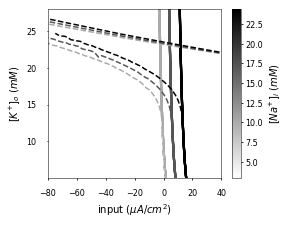

In [11]:
###################################
### Plot bifurcation diagram ######
###################################
### Importing the format for figures..
import json
P= json.load(open("cfg/PLOSmpl.json")) # import plot parameter
matplotlib.rcParams.update([(j,k) for (j,k) in P.items()
                            if j in matplotlib.rcParams.keys()])

plt.close("all")

fig_wide=matplotlib.rcParams["figure.figsize"][0]
fig_height=matplotlib.rcParams["figure.figsize"][1]

fig01 = plt.figure(facecolor="1",figsize=(fig_wide,fig_height*0.8))
axpl = plt.subplot2grid((29,16), (0, 2), colspan=12,rowspan=25)

s_x=1;s_y=0
cm = plt.cm.get_cmap('binary')
colors = iter(cm(np.linspace(0.2,0.8,len(a_d_Bif_graph_data)+3)))

##### Resolution reduction
nss=20

v_xx=[]
v_yy=[]
v_zz=[]
for d_Bif_graph_data in a_d_Bif_graph_data:
    v_xx.append(d_Bif_graph_data['saddle_node_par'][s_x][::nss])
    v_yy.append(d_Bif_graph_data['saddle_node_par'][s_y][::nss])
    v_zz.append(np.ones(len(d_Bif_graph_data['saddle_node_par'][s_y][::nss]))*d_Bif_graph_data['d_pars']['Na_i'])

##### plot saddle node bifurcation, hopf and limit cycle onset (HOM)
sc=axpl.scatter(np.concatenate(v_xx),np.concatenate(v_yy),5,c=np.concatenate(v_zz),cmap=cm,lw = 0)
for d_Bif_graph_data in a_d_Bif_graph_data:
    axpl.plot(d_Bif_graph_data['limit_cycle_onset_par'][s_x][::nss],d_Bif_graph_data['limit_cycle_onset_par'][s_y][::nss],'--',color=sc.to_rgba(d_Bif_graph_data['d_pars']['Na_i']),label='limit cycle onset')
    axpl.plot(d_Bif_graph_data['Hopf_par'][s_x],d_Bif_graph_data['Hopf_par'][s_y],'--',color=sc.to_rgba(d_Bif_graph_data['d_pars']['Na_i']),label='Hopf')


    
xlim=[-80,40]
ylim=[5.1,28]
axpl.set_xlim(xlim)
axpl.set_ylim(ylim)


##### Plot axes
axpl.set_ylabel('${[K^{+}]}_o$ $(mM)$')
axpl.set_xlabel('input $(\mu A/cm^2)$')
axpl.tick_params(axis='y', pad=10)
axpl.tick_params(axis='x', pad=10)

##### Nai
cbar = plt.colorbar(sc)
cbar.set_label('${[{Na}^{+}]}_i$ $(mM)$')


plt.show()
